In [14]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import sklearn.neighbors as knn
import and_logic_generator as and_gen
import utils
import applicability_domain as ad

# reload modules every 2 seconds
%load_ext autoreload
%autoreload 2


In [15]:
# Repeatable seed
random_state = 2**12
np.random.seed(seed=random_state)


In [16]:
n = 1000
x, y = and_gen.generate_samples(1000, random_state=random_state)


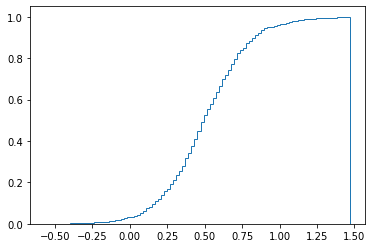

In [17]:
bins = 100
plt.figure()
plt.hist(x[:,0], bins, density=True, histtype='step', cumulative=True, label='CDF')
plt.show()


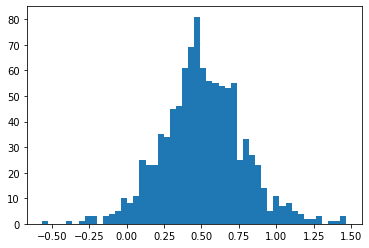

In [18]:
plt.figure()
count, bins, ignored = plt.hist(x[:,0], bins=50)
plt.show()


In [19]:
# 1/4 of the samples should output 1
print(y[y == 1].size/n)


0.24


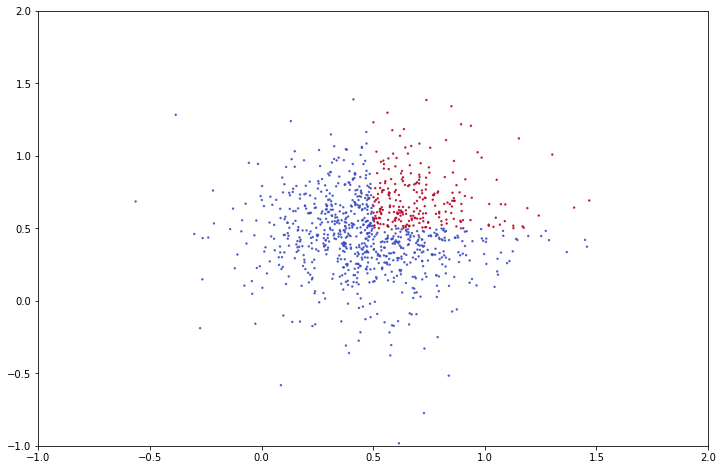

In [20]:
# Increasing the size of the plots
figsize = np.array(plt.rcParams["figure.figsize"]) * 2

x_min, x_max = -1.0, 2

plt.figure(figsize=figsize.tolist())
plt.scatter(
    x[:, 0], x[:, 1], marker='.', c=y, alpha=0.8, cmap='coolwarm',
    s=8, edgecolor='face')
plt.grid(False)
plt.xlim(x_min, x_max)
plt.ylim(x_min, x_max)
plt.show()


In [21]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)


In [22]:
# SVM
gamma = 10.0
C = 1000
model_svm1 = svm.SVC(
    kernel='rbf', decision_function_shape='ovo',
    random_state=random_state, gamma=gamma, C=C)
model_svm1.fit(x_train, y_train)


SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma=10.0, kernel='rbf',
    max_iter=-1, probability=False, random_state=4096, shrinking=True,
    tol=0.001, verbose=False)

In [23]:
print(f'With gamma = {gamma} and C = {C}')

y_pred = model_svm1.predict(x_train)
score = accuracy_score(y_train, y_pred)
print(f'Accuracy on train set = {score*100:.4f}%')

y_pred = model_svm1.predict(x_test)
score = accuracy_score(y_test, y_pred)
print(f'Accuracy on test set = {score*100:.4f}%')


With gamma = 10.0 and C = 1000
Accuracy on train set = 99.3750%
Accuracy on test set = 97.5000%


In [24]:
print(model_svm1.predict([[1., 1.]]))
print(model_svm1.predict([[1., 0.]]))
print(model_svm1.predict([[0., 1.]]))
print(model_svm1.predict([[0., 0.]]))


[1]
[0]
[0]
[0]


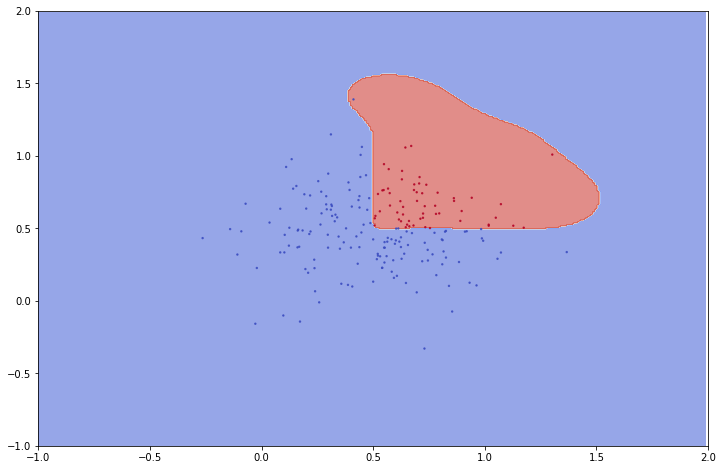

In [25]:
h = .01
# by symmetry x and y axis should be in same range
# x_min, x_max = x_test[:, 0].min() - 1, x_test[:, 0].max() + 1
x_min, x_max = -1.0, 2

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(x_min, x_max, h))
Z = model_svm1.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=figsize.tolist())
plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.6)
plt.scatter(
    x_test[:, 0], x_test[:, 1], c=y_test, marker='.', alpha=0.8,
    cmap='coolwarm', s=8, edgecolor='face')
plt.xlim(x_min, x_max)
plt.ylim(x_min, x_max)
plt.show()


In [26]:
def print_adversarial_examples(model):
    print(f'0.530 ^ 1.420 = {model_svm1.predict([[.53, 1.42]])[0]}')
    print(f'0.540 ^ 1.420 = {model_svm1.predict([[.54, 1.42]])[0]}')
    print(f'0.540 ^ 1.430 = {model_svm1.predict([[.54, 1.43]])[0]}\n')

    print(f'0.530 ^ 1.430 = {model_svm1.predict([[.53, 1.43]])[0]}')
    print(f'0.520 ^ 1.430 = {model_svm1.predict([[.52, 1.43]])[0]}\n')

    print(f'0.500 ^ 0.499 = {model_svm1.predict([[.5, .499]])[0]}')
    print(f'0.501 ^ 0.510 = {model_svm1.predict([[.501, .51]])[0]}')


In [27]:
print_adversarial_examples(model_svm1)


0.530 ^ 1.420 = 1
0.540 ^ 1.420 = 1
0.540 ^ 1.430 = 1

0.530 ^ 1.430 = 1
0.520 ^ 1.430 = 1

0.500 ^ 0.499 = 0
0.501 ^ 0.510 = 0


In [28]:
model_svm1.get_params()


{'C': 1000,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovo',
 'degree': 3,
 'gamma': 10.0,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 4096,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

 ### SVM with overfit parameter

 By increasing gamma, kernel function works better in the center.

In [29]:
gamma = 60.0
C = 1000
model_svm2 = svm.SVC(kernel='rbf', decision_function_shape='ovo',
                     random_state=random_state, gamma=gamma, C=C)
model_svm2.fit(x_train, y_train)


SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma=60.0, kernel='rbf',
    max_iter=-1, probability=False, random_state=4096, shrinking=True,
    tol=0.001, verbose=False)

In [30]:
print(f'With gamma = {gamma} and C = {C}')
y_pred = model_svm2.predict(x_train)
score = accuracy_score(y_train, y_pred)
print(f'Accuracy on train set = {score*100:.4f}%')

y_pred = model_svm2.predict(x_test)
score = accuracy_score(y_test, y_pred)
print(f'Accuracy on test set = {score*100:.4f}%')


With gamma = 60.0 and C = 1000
Accuracy on train set = 100.0000%
Accuracy on test set = 99.0000%


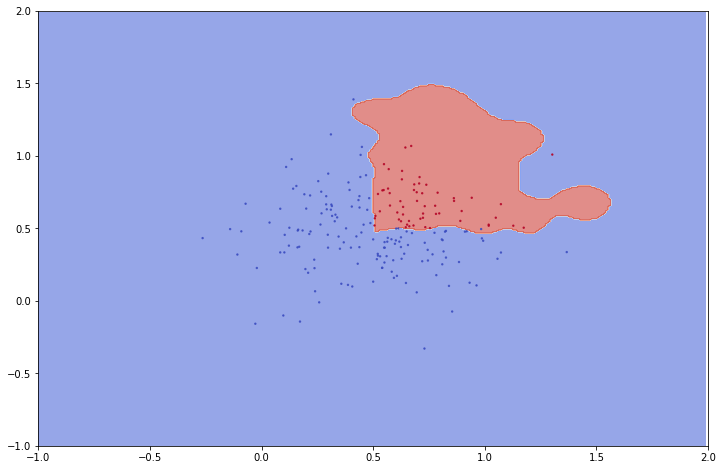

In [31]:
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(x_min, x_max, h))
Z = model_svm2.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=figsize.tolist())
plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.6)
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test, marker='.',
            alpha=0.8, cmap='coolwarm', s=8, edgecolor='face')
plt.xlim(x_min, x_max)
plt.ylim(x_min, x_max)
plt.show()


In [32]:
print_adversarial_examples(model_svm2)


0.530 ^ 1.420 = 1
0.540 ^ 1.420 = 1
0.540 ^ 1.430 = 1

0.530 ^ 1.430 = 1
0.520 ^ 1.430 = 1

0.500 ^ 0.499 = 0
0.501 ^ 0.510 = 0


In [33]:
model_svm2.get_params()


{'C': 1000,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovo',
 'degree': 3,
 'gamma': 60.0,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 4096,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

 ## Conclusion

 The adversarial examples exist in both models, but in different regions.

 ## Neural Network Model

In [34]:
model_nn = keras.Sequential([
    keras.layers.Dense(2,
                       input_shape=(2,),
                       activation='relu',
                       kernel_initializer=tf.initializers.GlorotNormal
                       ),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])


In [35]:
model_nn.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])


In [36]:
model_nn.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2)                 6         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


In [37]:
epochs = 20
batch_size = 32
model_nn.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
model_nn.evaluate(x_test, y_test, verbose=2)


200/1 - 0s - loss: 0.4038 - accuracy: 0.8150


[0.37954068660736084, 0.815]

In [38]:
model_nn.weights


[<tf.Variable 'dense/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[-0.32382017, -1.363456  ],
        [-0.16893663, -1.2870513 ]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(2,) dtype=float32, numpy=array([-0.12982619,  1.8843738 ], dtype=float32)>,
 <tf.Variable 'dense_1/kernel:0' shape=(2, 1) dtype=float32, numpy=
 array([[-0.05116741],
        [-3.3499684 ]], dtype=float32)>,
 <tf.Variable 'dense_1/bias:0' shape=(1,) dtype=float32, numpy=array([0.17976485], dtype=float32)>]

In [39]:
print(f'1 ^ 1 = {model_nn.predict([[1.0, 1.0]])[0][0]:.4f}')
print(f'0 ^ 1 = {model_nn.predict([[.0, 1.0]])[0][0]:.4f}')
print(f'1 ^ 0 = {model_nn.predict([[1.0, .0]])[0][0]:.4f}')
print(f'1 ^ 0 = {model_nn.predict([[.0, .0]])[0][0]:.4f}')


1 ^ 1 = 0.5448
0 ^ 1 = 0.1393
1 ^ 0 = 0.1729
1 ^ 0 = 0.0022


In [40]:
print(f'0.530 ^ 1.420 = {model_nn.predict([[.53, 1.42]])[0][0]:.4f}')
print(f'0.540 ^ 1.420 = {model_nn.predict([[.54, 1.42]])[0][0]:.4f}')
print(f'0.540 ^ 1.430 = {model_nn.predict([[.54, 1.43]])[0][0]:.4f}\n')

print(f'0.530 ^ 1.430 = {model_nn.predict([[.53, 1.43]])[0][0]:.4f}')
print(f'0.520 ^ 1.430 = {model_nn.predict([[.52, 1.43]])[0][0]:.4f}\n')

print(f'0.500 ^ 0.499 = {model_nn.predict([[.5, .499]])[0][0]:.4f}')
print(f'0.501 ^ 0.510 = {model_nn.predict([[.501, .51]])[0][0]:.4f}')


0.530 ^ 1.420 = 0.5448
0.540 ^ 1.420 = 0.5448
0.540 ^ 1.430 = 0.5448

0.530 ^ 1.430 = 0.5448
0.520 ^ 1.430 = 0.5448

0.500 ^ 0.499 = 0.1548
0.501 ^ 0.510 = 0.1617


 ## Applicability Domain

In [41]:
# all positive samples
x_pos = x_train[np.where(y_train == 1)]
x_pos_max = np.amax(x_pos, axis=0)
x_pos_min = np.amin(x_pos, axis=0)
print('Positive range:')
print(f'{x_pos_min[0]:.4f} <= x1 <= {x_pos_max[0]:.4f}')
print(f'{x_pos_min[1]:.4f} <= x2 <= {x_pos_max[1]:.4f}')

# all negative samples
x_neg = x_train[np.where(y_train == 0)]
x_neg_max = np.amax(x_neg, axis=0)
x_neg_min = np.amin(x_neg, axis=0)
print('\nNegative range:')
print(f'{x_neg_min[0]:.4f} <= x1 <= {x_neg_max[0]:.4f}')
print(f'{x_neg_min[1]:.4f} <= x2 <= {x_neg_max[1]:.4f}')


Positive range:
0.5008 <= x1 <= 1.4680
0.5006 <= x2 <= 1.3855

Negative range:
-0.5646 <= x1 <= 1.4574
-1.1868 <= x2 <= 1.2836


 ### Creating adversarial test set

In [42]:
# Hand picked samples which contain Adversarial Examples
x_ae = np.array([
    # standard
    [1.0000, 1.0000],  # 1
    [1.0000, 0.0000],  # 0
    [0.0000, 1.0000],  # 0
    [0.0000, 0.0000],  # 0
    # top centre
    [0.5200, 1.4300],  # 1
    [0.5100, 1.4300],  # 1
    [0.4900, 1.4300],  # 0
    [0.4900, 1.4500],  # 0
    # centre
    [0.5020, 0.4990],  # 0
    [0.5010, 0.4990],  # 0
    [0.4990, 0.5010],  # 0
    [0.4980, 0.5010],  # 0
    [0.5010, 0.5010],  # 1
    [0.5020, 0.5010],  # 1
    [0.5010, 0.5020],  # 1
    [0.5020, 0.5020],  # 1
    # out of training range
    # positive
    [0.5003, 1.0000],  # 1
    [1.0000, 0.5001],  # 1
    [1.4584, 1.0000],  # 1
    [1.0000, 1.4010],  # 1
    # negative
    [-0.7756,  0.0000],  # 0
    [1.4500,  0.0000],  # 0
    [0.0000, -0.9839],  # 0
    [0.0000,  1.4690]   # 0
])

y_ae = and_gen.get_y(x_ae)
print(*y_ae, sep=', ')


1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0


In [43]:
def print_misclassified_samples(x, y, pred):
    ind_mis = np.where(np.logical_xor(y, pred) == True)
    for xx, yy, pp in zip(x[ind_mis], y[ind_mis], pred[ind_mis]):
        print(f'[{xx[0]: .4f}, {xx[1]: .4f}] y = {yy} pred = {pp}')


In [44]:
# Do NOT change the initial predictions
pred_ae = tuple(model_svm1.predict(x_ae))
print('Misclassified samples:')
print_misclassified_samples(x_ae, y_ae, np.array(pred_ae))


Misclassified samples:
[ 0.4900,  1.4300] y = 0 pred = 1
[ 0.4900,  1.4500] y = 0 pred = 1
[ 0.5010,  0.5010] y = 1 pred = 0
[ 0.5020,  0.5010] y = 1 pred = 0
[ 0.5010,  0.5020] y = 1 pred = 0
[ 0.5020,  0.5020] y = 1 pred = 0
[ 1.4584,  1.0000] y = 1 pred = 0
[ 1.0000,  1.4010] y = 1 pred = 0


 ### Stage 1 - Check Applicability Domain

In [45]:
# Testing Applicability Domain
x_ad, ind_ad = ad.check_applicability(x_ae, x_train, y_train)
print(f'Pass rate = {len(x_ad) / len(x_ae) * 100.0:.4f}%')



Pass rate = 70.8333%


In [46]:
ind_blocked = utils.get_filtered_indices(x_ae, ind_ad)
print('Blocked by Bounding box (Applicability Domain):')
for x in x_ae[ind_blocked]:
    print(f'[{x[0]: .4f}, {x[1]: .4f}]')


Blocked by Bounding box (Applicability Domain):
[ 0.5200,  1.4300]
[ 0.5100,  1.4300]
[ 0.4900,  1.4300]
[ 0.4900,  1.4500]
[ 1.0000,  1.4010]
[-0.7756,  0.0000]
[ 0.0000,  1.4690]


 ### Stage 2 - Check Reliability Domain

In [47]:
# # of neighbours in kNN model
k = 9


In [48]:
# Build one model for each class.
ind_train_pos = np.where(y_train == 1)
model_knn_pos = utils.unimodal_knn(x_train[ind_train_pos], k)

ind_train_neg = np.where(y_train == 0)
model_knn_neg = utils.unimodal_knn(x_train[ind_train_neg], k)


In [49]:
mu_pos_dist, sd_pos_dist = utils.get_distance_info(
    model_knn_pos, x_train[ind_train_pos], k, seen_in_train_set=True)
print('Distance of positive samples in training set:')
print('{:18s} = {:.4f}'.format('Mean', mu_pos_dist))
print('{:18s} = {:.4f}\n'.format('Standard deviation', sd_pos_dist))

mu_neg_dist, sd_neg_dist = utils.get_distance_info(
    model_knn_neg, x_train[ind_train_neg], k, seen_in_train_set=True)
print('Distance of negative samples in training set:')
print('{:18s} = {:.4f}'.format('Mean', mu_neg_dist))
print('{:18s} = {:.4f}\n'.format('Standard deviation', sd_neg_dist))


Distance of positive samples in training set:
Mean               = 0.0637
Standard deviation = 0.0526

Distance of negative samples in training set:
Mean               = 0.0571
Standard deviation = 0.0660



In [50]:
# parameter for proportion
# 95%
zeta = 1.959


In [51]:
pos_dist_threshold = ad.get_reliability_threshold(
    mu_pos_dist, sd_pos_dist, zeta)
neg_dist_threshold = ad.get_reliability_threshold(
    mu_neg_dist, sd_neg_dist, zeta)
print(f'Positive distance threshold = {pos_dist_threshold:.4f}')
print(f'Negative distance threshold = {neg_dist_threshold:.4f}')


Positive distance threshold = 0.1667
Negative distance threshold = 0.1865


In [52]:
# Testing reliability domain
x_passed_rd, idx_within_rd = ad.check_reliability(
    x_ae, np.array(pred_ae), [model_knn_neg, model_knn_pos],
    [neg_dist_threshold, pos_dist_threshold], verbose=1)
print(f'\nPass rate = {len(x_passed_rd) / len(x_ae) * 100.0:.4f}%')



In 0 class:
Threshold = 0.1865
[ 1.0000,  0.0000] mean = 0.1881
[ 0.0000,  1.0000] mean = 0.1675
[ 0.0000,  0.0000] mean = 0.1547
[ 0.5020,  0.4990] mean = 0.0237
[ 0.5010,  0.4990] mean = 0.0231
[ 0.4990,  0.5010] mean = 0.0211
[ 0.4980,  0.5010] mean = 0.0205
[ 0.5010,  0.5010] mean = 0.0223
[ 0.5020,  0.5010] mean = 0.0230
[ 0.5010,  0.5020] mean = 0.0220
[ 0.5020,  0.5020] mean = 0.0227
[ 1.4584,  1.0000] mean = 0.6131
[ 1.0000,  1.4010] mean = 0.6832
[-0.7756,  0.0000] mean = 0.6682
[ 1.4500,  0.0000] mean = 0.4312
[ 0.0000, -0.9839] mean = 0.6793
[ 0.0000,  1.4690] mean = 0.4787
Passed indices:
2, 3, 8, 9, 10, 11, 12, 13, 14, 15

In 1 class:
Threshold = 0.1667
[ 1.0000,  1.0000] mean = 0.1509
[ 0.5200,  1.4300] mean = 0.2819
[ 0.5100,  1.4300] mean = 0.2861
[ 0.4900,  1.4300] mean = 0.2953
[ 0.4900,  1.4500] mean = 0.3107
[ 0.5003,  1.0000] mean = 0.0832
[ 1.0000,  0.5001] mean = 0.0981
Passed indices:
0, 16, 17

Pass rate = 54.1667%


In [53]:
blocked_ind = utils.get_filtered_indices(x_ae, idx_within_rd)
print(f'# of blocked samples = {len(blocked_ind)}')
print('Blocked by in-class kNN (Reliability Domain):')
for x in x_ae[blocked_ind]:
    print(f'[{x[0]: .4f}, {x[1]: .4f}]')


# of blocked samples = 11
Blocked by in-class kNN (Reliability Domain):
[ 1.0000,  0.0000]
[ 0.5200,  1.4300]
[ 0.5100,  1.4300]
[ 0.4900,  1.4300]
[ 0.4900,  1.4500]
[ 1.4584,  1.0000]
[ 1.0000,  1.4010]
[-0.7756,  0.0000]
[ 1.4500,  0.0000]
[ 0.0000, -0.9839]
[ 0.0000,  1.4690]


In [54]:
# Check
print('Script for testing [1.4584, 1.0000]:')

chec_pred = model_svm1.predict([[1.4584, 1.0000]])
print(f'Prediction from SVM model = {chec_pred[0]}\n')

chec_dist, _ = model_knn_pos.kneighbors(
    [[1.4584, 1.0000]], n_neighbors=k, return_distance=True)
print('Using positive kNN model:')
print(chec_dist[0])
print(np.mean(chec_dist, axis=1)[0])

chec_dist, _ = model_knn_neg.kneighbors(
    [[1.4584, 1.0000]], n_neighbors=k, return_distance=True)
print('\nUsing negative kNN model:')
print(chec_dist[0])
print(np.mean(chec_dist, axis=1)[0])


Script for testing [1.4584, 1.0000]:
Prediction from SVM model = 0

Using positive kNN model:
[0.30794297 0.32866899 0.36129523 0.43761094 0.44930369 0.46533385
 0.47300149 0.49147412 0.49663363]
0.42347387937399783

Using negative kNN model:
[0.54975148 0.57930159 0.59026637 0.6057775  0.6127662  0.62633504
 0.64031917 0.65481327 0.65883272]
0.6131292579050941


 ### Conclusion - Stage 2
 When the predictions are different between kNN and original model (SVM in this case), the average distance from the misclassified kNN model will greater than  the correct kNN model.
 As the result, this sample is more likely to be blocked by reliability domain.

 ### Stage 3 - Decidability Domian

In [55]:
# Decidability Domian uses the kNN model which is trained by the entire training
# set.
# Using the same value from Reliability Domain.
print(f'k = {k}')
model_knn = knn.KNeighborsClassifier(
    n_neighbors=k,
    n_jobs=-1,
    weights='distance'
)
model_knn.fit(x_train, y_train)


k = 9


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=9, p=2,
                     weights='distance')

In [56]:
# Testing Decidability Domain
x_passed_dd, idx_within_dd = ad.check_decidability(
    x_ae, np.array(pred_ae), model_knn, verbose=1)
print(f'\nPass rate = {len(x_passed_dd) / len(x_ae) * 100.0:.4f}%')


Prediction from kNN:
1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0
Expected outputs:
1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0
Matched indices:
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 21, 22, 23
# of inputs = 24
# of passed = 22

Pass rate = 91.6667%


In [57]:
def print_blocked_samples(x, ind_passed):
    ind_blocked = utils.get_filtered_indices(x, ind_passed)
    for x_i in x[ind_blocked]:
        print(f'[{x_i[0]: .4f}, {x_i[1]: .4f}]')


 ## Full pipeline
 The entire pipeline for AD

In [58]:
# Preparing the test set
x_new = x_ae
y_new = and_gen.get_y(x_new)

# Prediction from the initial model
model = model_svm1
pred_new = model.predict(x_new)

score = accuracy_score(y_new, pred_new)
print(f'Accuracy on the given set = {score*100:.4f}%')

print('Misclassified samples:')
print_misclassified_samples(x_new, y_new, np.array(pred_new))

# Applicability Domain
# Stage 1 - Applicability
print('\n---------- Applicability ---------------')
x_passed_s1, ind_passed_s1 = ad.check_applicability(x_new, x_train, y_train)
y_passed_s1 = y_new[ind_passed_s1]

# Print infomation

pass_rate_ad = utils.get_rate(x_passed_s1, x_new)
print(f'Pass rate = {pass_rate_ad * 100:.4f}%')
print('Blocked by Applicability Domain:')
print_blocked_samples(x_new, ind_passed_s1)

# State 2 - Reliability
print('\n---------- Reliability -----------------')
# Parameters:
k = 9
zeta = 1.959

# Creating kNN models for each class
ind_train_c1 = np.where(y_train == 1)
model_knn_c1 = utils.unimodal_knn(x_train[ind_train_c1], k)

ind_train_c0 = np.where(y_train == 0)
model_knn_c0 = utils.unimodal_knn(x_train[ind_train_c0], k)

# Computing mean, standard deviation and threshold
mu_c1, sd_c1 = utils.get_distance_info(
    model_knn_c1, x_train[ind_train_c1], k, seen_in_train_set=True)
threshold_c1 = ad.get_reliability_threshold(mu_c1, sd_c1, zeta)

mu_c0, sd_c0 = utils.get_distance_info(
    model_knn_c0, x_train[ind_train_c0], k, seen_in_train_set=True)
threshold_c0 = ad.get_reliability_threshold(mu_c0, sd_c0, zeta)

x_passed_s2, ind_passed_s2 = ad.check_reliability(
    x_passed_s1,
    predictions=y_passed_s1,
    models=[model_knn_c0, model_knn_c1],
    dist_thresholds=[threshold_c0, threshold_c1],
    classes=[0, 1]
)
y_passed_s2 = y_passed_s1[ind_passed_s2]

# Print infomation
print('Distance of c1 in training set:')
print('{:18s} = {:.4f}'.format('Mean', mu_c1))
print('{:18s} = {:.4f}'.format('Standard deviation', sd_c1))
print('{:18s} = {:.4f}\n'.format('Threshold', threshold_c1))

print('Distance of c0 in training set:')
print('{:18s} = {:.4f}'.format('Mean', mu_c0))
print('{:18s} = {:.4f}'.format('Standard deviation', sd_c0))
print('{:18s} = {:.4f}\n'.format('Threshold', threshold_c0))

pass_rate_rd = utils.get_rate(x_passed_s2, x_passed_s1)
print(f'Pass rate = {pass_rate_rd * 100:.4f}%')
print('Blocked by Reliability Domain:')
print_blocked_samples(x_passed_s1, ind_passed_s2)

# Stage 3 - Decidability
print('\n---------- Decidability ----------------')
model_knn = knn.KNeighborsClassifier(
    n_neighbors=k, n_jobs=-1, weights='distance')
model_knn.fit(x_train, y_train)

x_passed_s3, ind_passed_s3 = ad.check_decidability(
    x_passed_s2, y_passed_s2, model_knn)
y_passed_s3 = y_passed_s2[ind_passed_s3]

# Print infomation
pass_rate_dd = utils.get_rate(x_passed_s3, x_passed_s2)
print(f'Pass rate = {pass_rate_dd * 100:.4f}%')
print('Blocked by Decidability Domain:')
print_blocked_samples(x_passed_s2, ind_passed_s3)


Accuracy on the given set = 66.6667%
Misclassified samples:
[ 0.4900,  1.4300] y = 0 pred = 1
[ 0.4900,  1.4500] y = 0 pred = 1
[ 0.5010,  0.5010] y = 1 pred = 0
[ 0.5020,  0.5010] y = 1 pred = 0
[ 0.5010,  0.5020] y = 1 pred = 0
[ 0.5020,  0.5020] y = 1 pred = 0
[ 1.4584,  1.0000] y = 1 pred = 0
[ 1.0000,  1.4010] y = 1 pred = 0

---------- Applicability ---------------
Pass rate = 70.8333%
Blocked by Applicability Domain:
[ 0.5200,  1.4300]
[ 0.5100,  1.4300]
[ 0.4900,  1.4300]
[ 0.4900,  1.4500]
[ 1.0000,  1.4010]
[-0.7756,  0.0000]
[ 0.0000,  1.4690]

---------- Reliability -----------------
Distance of c1 in training set:
Mean               = 0.0637
Standard deviation = 0.0526
Threshold          = 0.1667

Distance of c0 in training set:
Mean               = 0.0571
Standard deviation = 0.0660
Threshold          = 0.1865

Pass rate = 76.4706%
Blocked by Reliability Domain:
[ 1.0000,  0.0000]
[ 1.4584,  1.0000]
[ 1.4500,  0.0000]
[ 0.0000, -0.9839]

---------- Decidability ----------

 ## Results

In [59]:
pass_rate = utils.get_rate(x_passed_s3, x_new)
print(f'\nOverall pass rate = {pass_rate * 100:.4f}%')
print('Passed samples:')
for x_i in x_passed_s3:
    print(f'[{x_i[0]: .4f}, {x_i[1]: .4f}]')

pred_after_ad = model.predict(x_passed_s3)

score = accuracy_score(y_passed_s3, pred_after_ad)
print(f'Accuracy on the given set = {score*100:.4f}%')



Overall pass rate = 37.5000%
Passed samples:
[ 1.0000,  1.0000]
[ 0.0000,  1.0000]
[ 0.0000,  0.0000]
[ 0.5020,  0.4990]
[ 0.5010,  0.4990]
[ 0.4990,  0.5010]
[ 0.4980,  0.5010]
[ 0.5003,  1.0000]
[ 1.0000,  0.5001]
Accuracy on the given set = 100.0000%
